In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt, floor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

## Load Data

In [46]:
df_tweets = pd.read_csv("../Data/trump_tweets.csv", parse_dates = ['date'], index_col=7)
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
date,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f
2009-05-05 01:00:00,1.701461e+09,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34,f
2009-05-08 13:38:00,1.737480e+09,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15,f
2009-05-08 20:40:00,1.741161e+09,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11,f
2009-05-12 14:07:00,1.773561e+09,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321,f


In [47]:
df_tweets.tail()

,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
date,,,,,,,,
2021-01-06 21:17:00,1.346930e+18,https://t.co/Pm2PKV0Fp3,f,f,Twitter for iPhone,0,0,f
2021-01-06 23:01:00,1.346950e+18,These are the things and events that happen wh...,f,f,Twitter for iPhone,0,0,f
2021-01-08 00:10:00,1.347330e+18,https://t.co/csX07ZVWGe,f,f,Twitter Media Studio,629326,154877,f
2021-01-08 14:46:00,1.347560e+18,"The 75,000,000 great American Patriots who vot...",f,f,Twitter for iPhone,480997,108844,f
2021-01-08 15:44:00,1.347570e+18,"To all of those who have asked, I will not be ...",f,f,Twitter for iPhone,510761,83532,f


In [48]:
df_doge = pd.read_csv("../Data/Daily-DOGE-USD.csv", parse_dates=['Date'], index_col=0)
df_doge.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0


In [49]:
df_doge.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-20,0.317571,0.333223,0.314142,0.327491,0.327491,3.512291e+09
2021-08-21,0.327395,0.329356,0.315433,0.316797,0.316797,2.600397e+09
2021-08-22,0.317085,0.321541,0.306546,0.314963,0.314963,2.237836e+09
2021-08-23,0.314926,0.328094,0.313368,0.317914,0.317914,2.836629e+09
2021-08-24,0.317984,0.319460,0.311619,0.312391,0.312391,2.088121e+09


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [50]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

In [51]:
# Aligning Tweet Data with Doge Data
df_tweets = df_tweets.loc[(df_tweets.index > '2017-08-24')]
# Dropping ID column since it's unexpected to be useful
df_tweets = df_tweets.drop(columns=['id'], axis=1)

# Changing by the second data to by the day data
changed1 = df_tweets.groupby([df_tweets.index.date]).size().reset_index(name='Tweet Count')
changed2 = df_tweets.groupby([df_tweets.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_tweets = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_tweets = df_tweets.rename_axis('Date')
df_tweets.head()

,Tweet Count,favorites,retweets
Date,,,
2017-08-24,15,553551,146247
2017-08-25,14,676700,148426
2017-08-26,12,577719,130227
2017-08-27,11,733628,144351
2017-08-28,4,0,68447


In [52]:
# Aligning Doge Data with Tweet Data
df_doge = df_doge.loc[(df_doge.index < '2021-01-08')]
#df_doge = df_doge.drop(columns=['Open', 'High', 'Low', 'Adj Close'], axis=1)
df_doge.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0


Text(0.5, 1.0, 'DogeCoin Close')

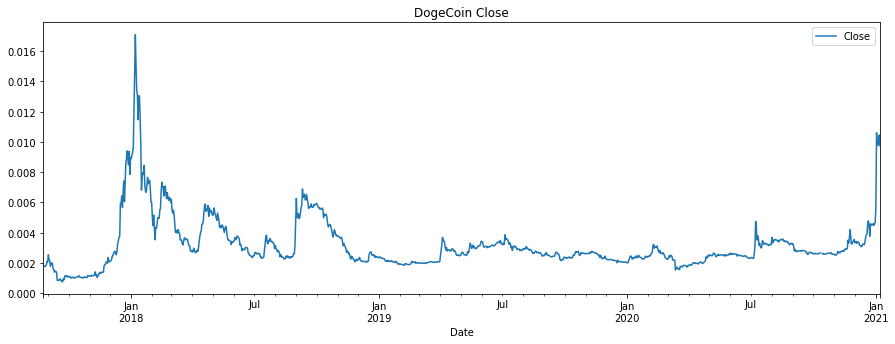

In [53]:
df_doge.plot(y='Close', figsize=(15,5)).set_title('DogeCoin Close')

In [54]:
# Merging Two Data Sets Together
df = df_doge.merge(df_tweets, how='outer', left_index=True, right_index=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Tweet Count,favorites,retweets
Date,,,,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0,15.0,553551.0,146247.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0,14.0,676700.0,148426.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0,12.0,577719.0,130227.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0,11.0,733628.0,144351.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0,4.0,0.0,68447.0


In [59]:
values = df.values

# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()

# ensure all data is float
values = values.astype('float32')
print(values.shape)
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[9, 10, 11, 13, 14, 15, 16, 17]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(1234, 9)
(1234, 9)
(1212, 10)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var4(t)
1,0.059255,0.059033,0.078561,0.064961,0.064961,0.001089,0.092105,0.067624,0.053674,0.063369
2,0.063964,0.058199,0.081428,0.063369,0.063369,0.000462,0.085526,0.082669,0.054548,0.062634
3,0.062680,0.056365,0.079493,0.062634,0.062634,0.000252,0.072368,0.070577,0.047250,0.061532
4,0.062190,0.055642,0.080209,0.061532,0.061532,0.000342,0.065789,0.089623,0.052914,0.065512
5,0.061273,0.057921,0.080639,0.065512,0.065512,0.000625,0.019737,0.000000,0.022473,0.068083


In [60]:
# split into train and test sets
values = reframed.values
n_train = floor(len(values) * 0.25)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(303, 1, 9) (303,) (909, 1, 9) (909,)


Epoch 1/100
7/7 - 2s - loss: 0.1780 - val_loss: 0.0851
Epoch 2/100
7/7 - 1s - loss: 0.1416 - val_loss: 0.0486
Epoch 3/100
7/7 - 1s - loss: 0.1150 - val_loss: 0.0311
Epoch 4/100
7/7 - 0s - loss: 0.0937 - val_loss: 0.0380
Epoch 5/100
7/7 - 0s - loss: 0.0806 - val_loss: 0.0484
Epoch 6/100
7/7 - 0s - loss: 0.0722 - val_loss: 0.0544
Epoch 7/100
7/7 - 0s - loss: 0.0659 - val_loss: 0.0553
Epoch 8/100
7/7 - 0s - loss: 0.0602 - val_loss: 0.0519
Epoch 9/100
7/7 - 0s - loss: 0.0546 - val_loss: 0.0460
Epoch 10/100
7/7 - 0s - loss: 0.0490 - val_loss: 0.0388
Epoch 11/100
7/7 - 0s - loss: 0.0434 - val_loss: 0.0315
Epoch 12/100
7/7 - 0s - loss: 0.0378 - val_loss: 0.0248
Epoch 13/100
7/7 - 0s - loss: 0.0325 - val_loss: 0.0184
Epoch 14/100
7/7 - 0s - loss: 0.0284 - val_loss: 0.0129
Epoch 15/100
7/7 - 0s - loss: 0.0253 - val_loss: 0.0096
Epoch 16/100
7/7 - 0s - loss: 0.0225 - val_loss: 0.0091
Epoch 17/100
7/7 - 0s - loss: 0.0207 - val_loss: 0.0094
Epoch 18/100
7/7 - 0s - loss: 0.0203 - val_loss: 0.0096
E

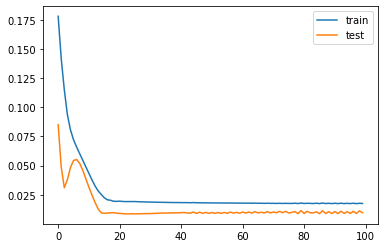

In [61]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [62]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [63]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.000
Normalized RMSE: 0.027


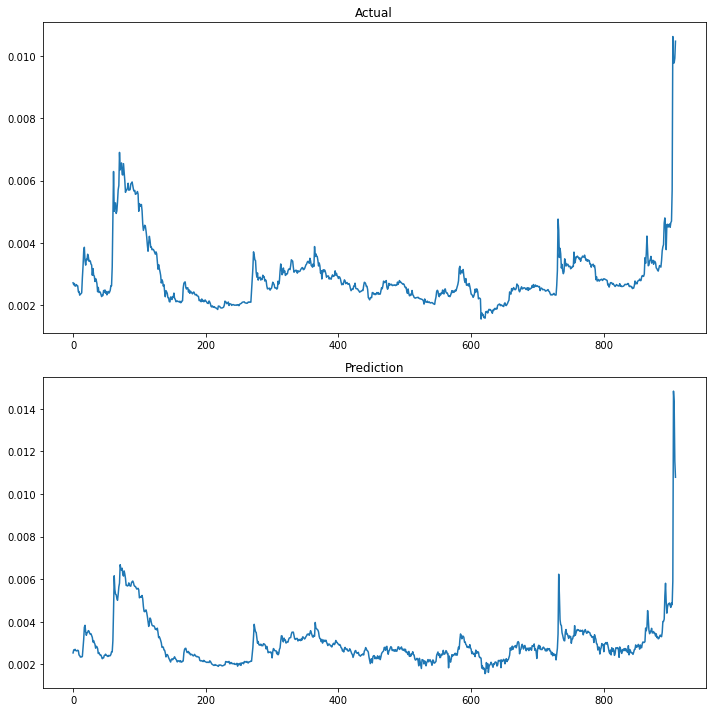

In [64]:
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Actual")
pyplot.title("Actual")
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction")
pyplot.tight_layout()
pyplot.show()